In [ ]:
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gc
import seaborn as sns


In [26]:
smpc_histogram_raw_path = "/data/raw_data/smpc_histogram_raw/"
smpc_histogram_processed_path = "/data/processed_data/smpc_histogram_processed/"

historical_path = smpc_histogram_raw_path + "cornell_weatherstation_2017.csv"
prediction_path = smpc_histogram_raw_path + "predicted_2017_weather_data.csv"

save_path = smpc_histogram_processed_path + "smpc_2017/"

if not os.path.exists(save_path):
      os.makedirs(save_path)


In [27]:
# read .csv file
def load_data(path):
  if os.path.exists(path):
    data = pd.read_csv(path, skiprows=2)

  else:
      print("No file found")
  return data

# prepare work
def prepare_data(df,with_zero):
  df['Time'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
  df_filtered = df[((df['Time'].dt.month) >= 5) & ((df['Time'].dt.month) <= 8)]
  if not(with_zero):
    df_filtered = df_filtered[df_filtered['DHI'] != 0]

  return df_filtered

In [38]:
def draw_bar(df,title, flag):
  #dhi_rounded = df // 10 * 10
  if flag:
    dhi_rounded = df // 10 * 10
    n =50
  else:
    dhi_rounded = (df // 10 * 10).replace(0, np.nan).dropna()
    n= 2

  dhi_frequency_rounded = dhi_rounded.value_counts().sort_index()

  colors = plt.cm.viridis(np.linspace(0.2, 1, len(dhi_frequency_rounded)))

  fig, ax = plt.subplots(figsize=(14, 8))


  bars = ax.bar(
      dhi_frequency_rounded.index,
      dhi_frequency_rounded.values,
      width=8,
      edgecolor='black',
      alpha=0.9,
      color=colors
  )


  for bar in bars:
    height = bar.get_height()
    if height > 0:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          height + n,
          f'{int(height)}',
          ha='center',
          va='bottom',
          fontsize=10,
          color='black'
      )

  # Title and labels
  ax.set_title("Frequency Distribution of DHI in " + title, fontsize=18, color='darkblue', pad=20)
  ax.set_xlabel("DHI (Rounded to Tens)", fontsize=14, labelpad=10)
  ax.set_ylabel("DHI Frequency", fontsize=14, labelpad=10)

  # Grid and style improvements
  ax.grid(axis='y', linestyle='--', alpha=0.6)
  ax.set_xticks(dhi_frequency_rounded.index)
  plt.setp(ax.get_xticklabels(), rotation=45, fontsize=12)
  ax.tick_params(axis='y', labelsize=12)


  sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=dhi_frequency_rounded.index.min(), vmax=dhi_frequency_rounded.index.max()))
  sm.set_array([])
  fig.colorbar(sm, ax=ax, label='DHI Ranges (Rounded to Tens)')


  plt.tight_layout()
  plt.savefig(save_path + "Frequency Distribution of DHI in " + title, dpi=300, bbox_inches='tight')
  print(f"Chart saved to {save_path}")
  plt.show()

In [45]:

def combined_bar(historical, predicted,title, flag):
  if flag:
    dhi_rounded_his = historical // 10 * 10
    dhi_rounded_pre = predicted // 10 * 10
    n =50
  else:
    dhi_rounded_his = (historical // 10 * 10).replace(0, np.nan).dropna()
    dhi_rounded_pre = (predicted // 10 * 10).replace(0, np.nan).dropna()
    n= 2



  dhi_frequency_rounded_his = dhi_rounded_his.value_counts().sort_index()
  dhi_frequency_rounded_pre = dhi_rounded_pre.value_counts().sort_index()
  comparison_index = dhi_frequency_rounded_his.index.union(dhi_frequency_rounded_pre.index)

  step = max(1, len(comparison_index) // 30)
  xticks_to_show = comparison_index[::step]


  plt.figure(figsize=(14, 8))

  # Bar chart for historical data
  bars_actual = plt.bar(
      comparison_index,
      dhi_frequency_rounded_his,
      width=4,
      label='Actual Data',
      color='blue',
      alpha=0.7,
      edgecolor='black'
  )

  # Bar chart for predicted data, stacked on the same bars
  bars_predicted = plt.bar(
      comparison_index,
      dhi_frequency_rounded_pre,
      width=4,
      label='Predicted Data',
      color='orange',
      alpha=0.7,
      edgecolor='black'
  )


  for actual, predicted, idx in zip(dhi_frequency_rounded_his, dhi_frequency_rounded_pre, comparison_index):
      diff = actual - predicted
      if abs(diff) >=0:
        plt.text(
            idx,
            max(actual, predicted) + 2,
            f'{int(diff)}',
            ha='center',
            fontsize=10,
            color='red' if diff < 0 else 'green'
        )

  # Add labels and title
  plt.title("Comparison of historical and Predicted DHI Frequencies", fontsize=18, pad=20)
  plt.xlabel("DHI (Rounded to Tens)", fontsize=14, labelpad=10)
  plt.ylabel("Frequency", fontsize=14, labelpad=10)


  plt.xticks(ticks=xticks_to_show, rotation=45, fontsize=12)
  plt.yticks(fontsize=12)

  # Add a legend
  plt.legend(fontsize=12)

  # Grid lines for better visualization
  plt.grid(axis='y', linestyle='--', alpha=0.6)


  plt.tight_layout()
  plt.savefig(save_path +title, dpi=300, bbox_inches='tight')
  print(f"Chart saved to {save_path}")

  plt.show()


In [48]:
# Plot the difference between actual and predicted data
def difference_bar(historical, predicted,title,flag):
  if flag:
    dhi_rounded_his = historical // 10 * 10
    dhi_rounded_pre = predicted // 10 * 10

  else:
    dhi_rounded_his = (historical // 10 * 10).replace(0, np.nan).dropna()
    dhi_rounded_pre = (predicted // 10 * 10).replace(0, np.nan).dropna()





  dhi_frequency_rounded_his = dhi_rounded_his.value_counts().sort_index()
  dhi_frequency_rounded_pre = dhi_rounded_pre.value_counts().sort_index()
  comparison_index = dhi_frequency_rounded_his.index.union(dhi_frequency_rounded_pre.index)
  dhi_difference = dhi_frequency_rounded_his - dhi_frequency_rounded_pre

  step = max(1, len(comparison_index) // 30)
  xticks_to_show = comparison_index[::step]


  plt.figure(figsize=(14, 8))

  # Create a bar chart showing differences
  bars = plt.bar(
      comparison_index,
      dhi_difference,
      color=['green' if diff >= 0 else 'red' for diff in dhi_difference],
      edgecolor='black',
      alpha=0.8
  )


  for bar, diff in zip(bars, dhi_difference):
    height = bar.get_height()
    if abs(height) > 0:
      plt.text(
          bar.get_x() + bar.get_width() / 2,
          height + (10 if height > 0 else -20),
          f'{int(diff)}',
          ha='center',
          va='bottom',
          fontsize=10,
          color='black'
      )

  # Add labels and title
  plt.title("Difference in DHI Frequencies Between Actual and Predicted Data", fontsize=18, pad=20)
  plt.xlabel("DHI (Rounded to Tens)", fontsize=14, labelpad=10)
  plt.ylabel("Frequency Difference", fontsize=14, labelpad=10)

  # Limit x-ticks for better readability
  plt.xticks(ticks=xticks_to_show, rotation=45, fontsize=12)
  plt.yticks(fontsize=12)

  # Grid lines for better visualization
  plt.grid(axis='y', linestyle='--', alpha=0.6)

  # Display the difference chart
  plt.tight_layout()

  plt.savefig(save_path +title, dpi=300, bbox_inches='tight')
  print(f"Chart saved to {save_path}")
  plt.show()


In [31]:
historical_data = load_data(historical_path)
prediction_data = load_data(prediction_path)
historical_data_withzero = prepare_data(historical_data, with_zero=True)
prediction_data_withzero = prepare_data(prediction_data, with_zero=True)
historical_data_filtered = prepare_data(historical_data, with_zero=False)
prediction_data_filtered = prepare_data(prediction_data, with_zero=False)

Chart saved to /data/processed_data/smpc_histogram_processed/smpc_2017/


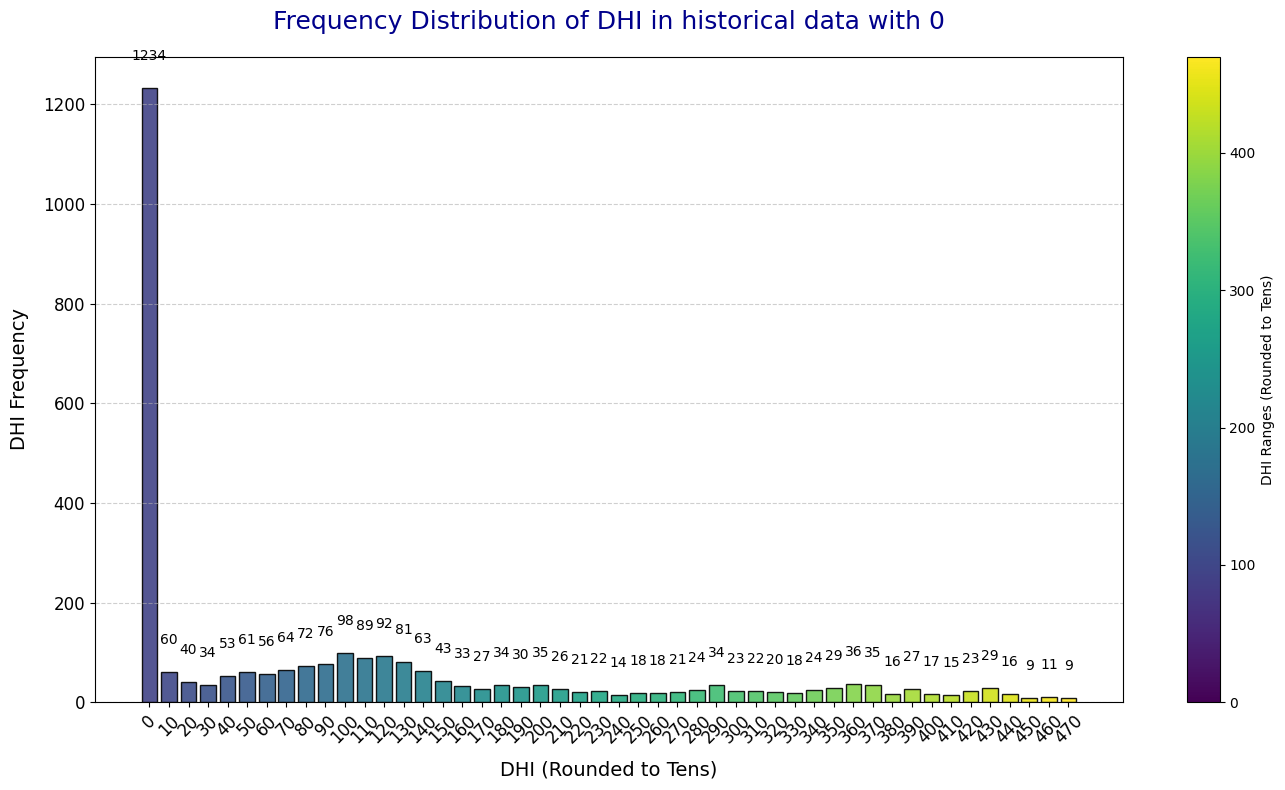

In [39]:
draw_bar(historical_data_withzero['DHI'], 'historical data with 0', flag=True)

Chart saved to /data/processed_data/smpc_histogram_processed/smpc_2017/


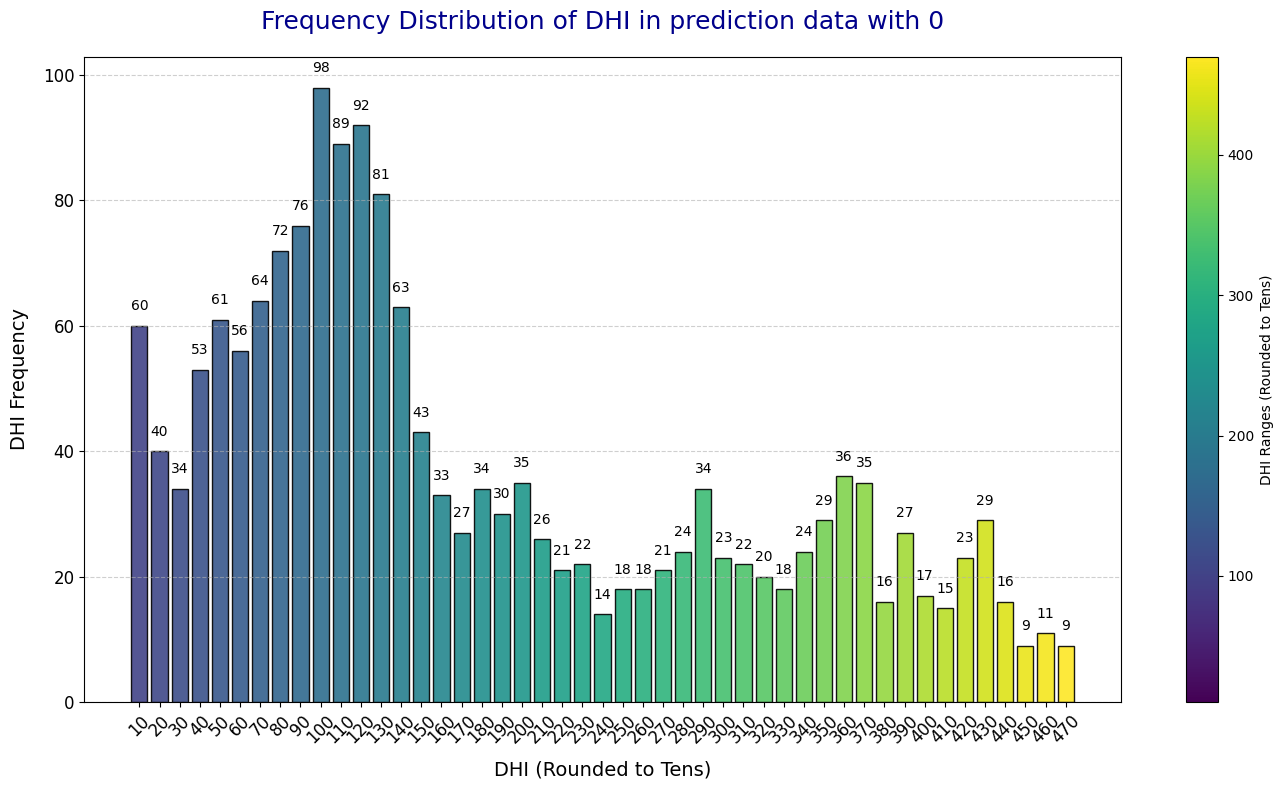

In [40]:
draw_bar(prediction_data_withzero['DHI'], 'prediction data with 0', flag=True)

Chart saved to /data/processed_data/smpc_histogram_processed/smpc_2017/


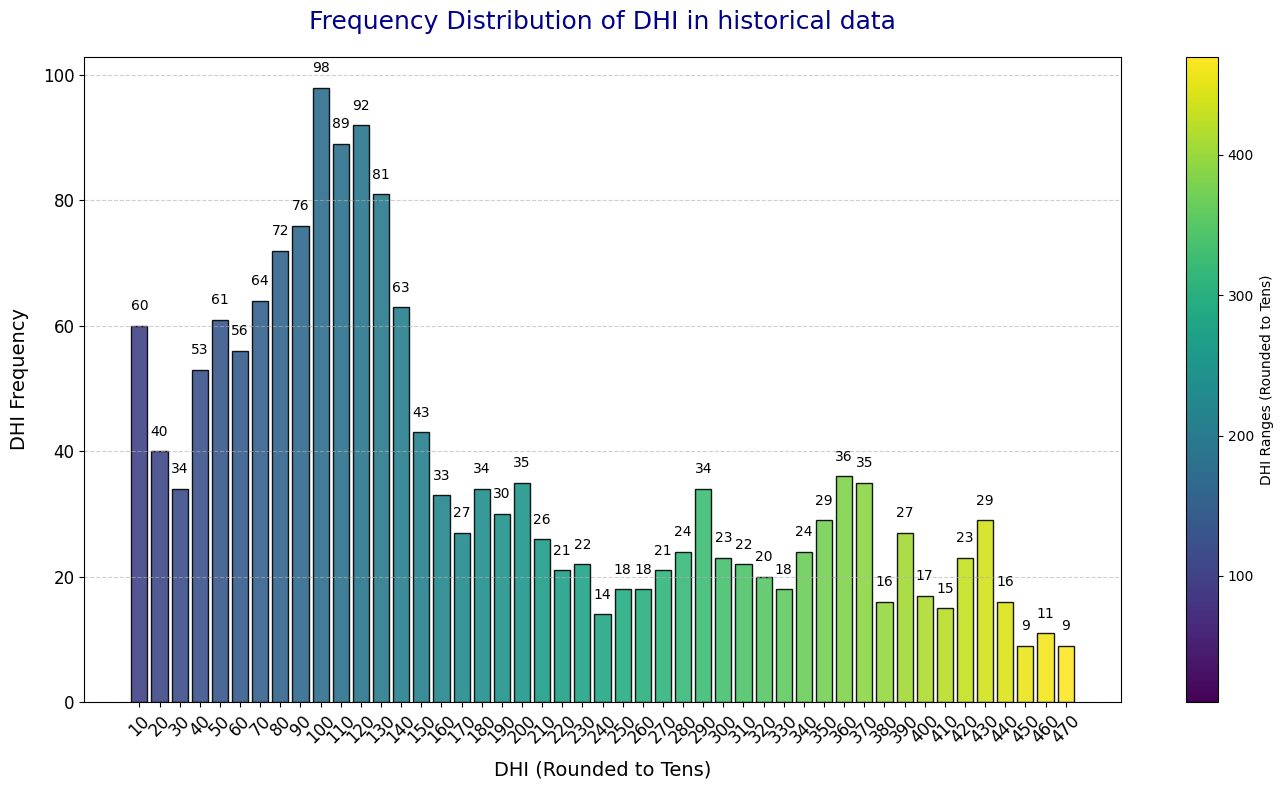

In [41]:
draw_bar(historical_data_filtered['DHI'], 'historical data', flag=False)

Chart saved to /data/processed_data/smpc_histogram_processed/smpc_2017/


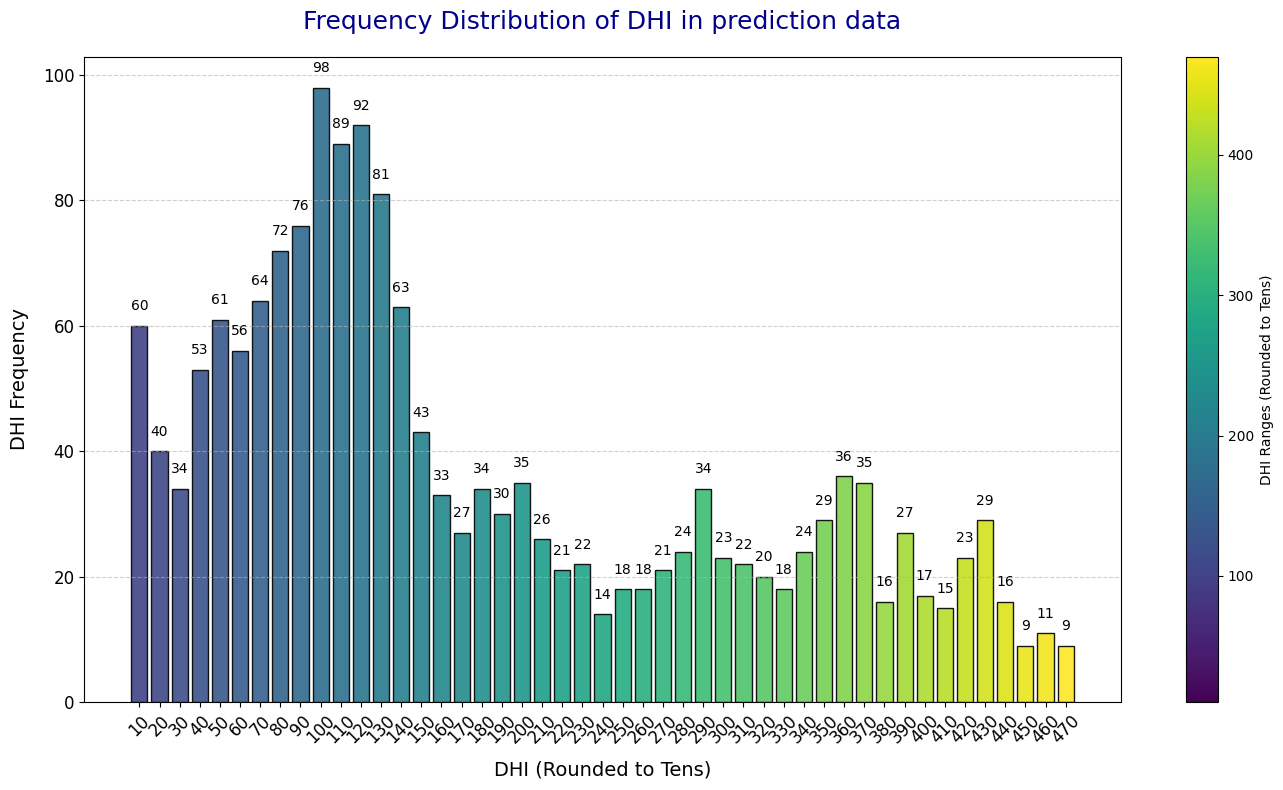

In [42]:
draw_bar(prediction_data_filtered['DHI'], 'prediction data', flag=False)

Chart saved to /data/processed_data/smpc_histogram_processed/smpc_2017/


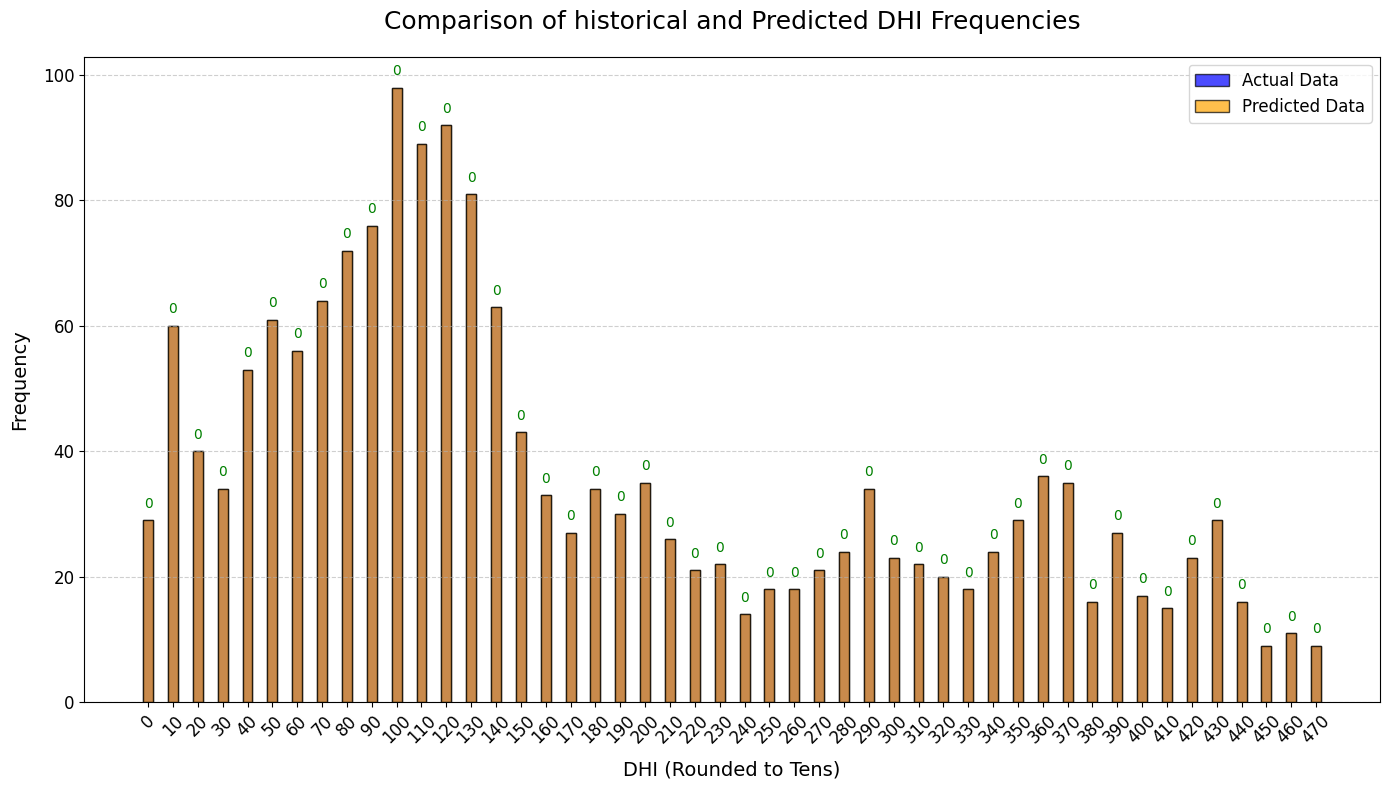

In [46]:
combined_bar(historical_data_filtered['DHI'], prediction_data_filtered['DHI'], "Comparison of historical and Predicted DHI Frequencies with 0", flag=True)

Chart saved to /data/processed_data/smpc_histogram_processed/smpc_2017/


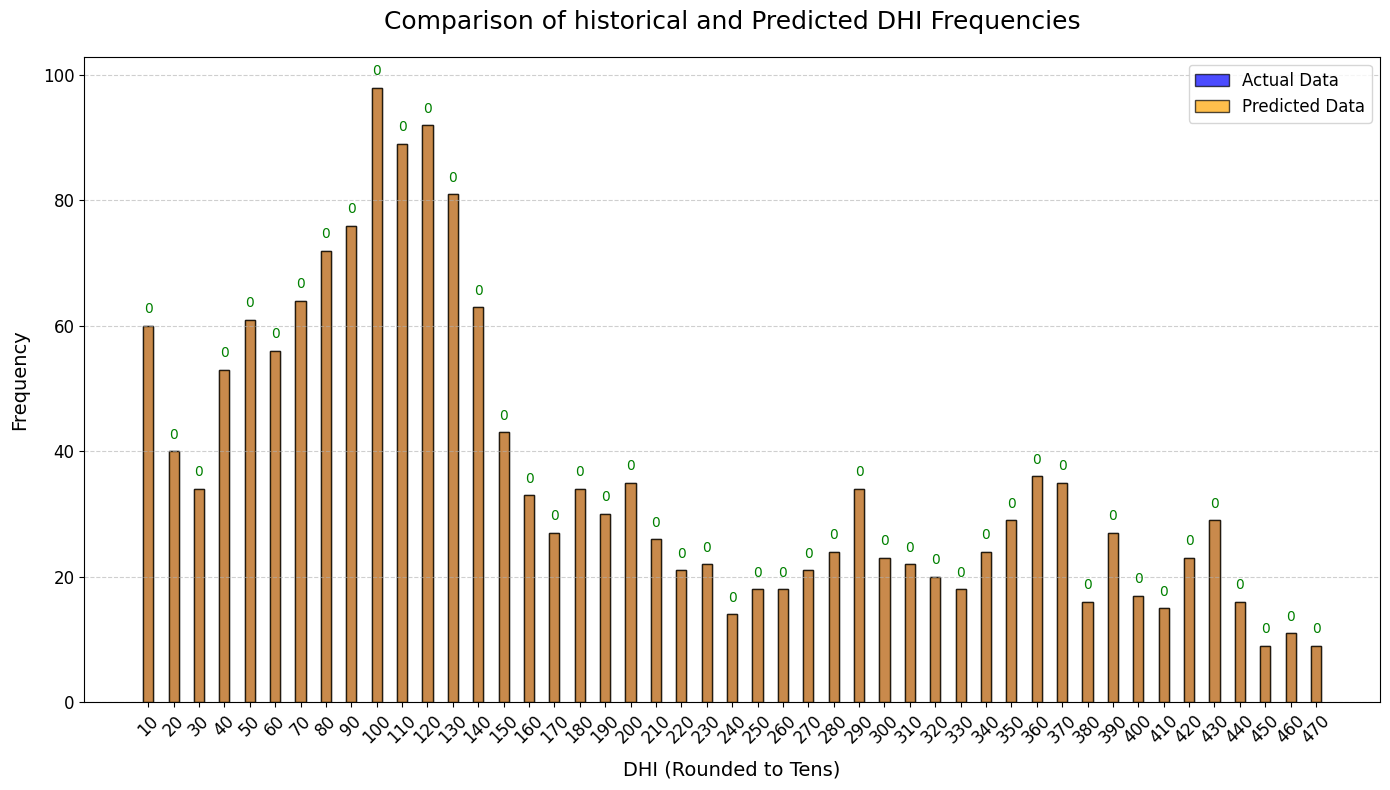

In [47]:
combined_bar(historical_data_filtered['DHI'], prediction_data_filtered['DHI'], "Comparison of historical and Predicted DHI Frequencies", flag=False)

Chart saved to /data/processed_data/smpc_histogram_processed/smpc_2017/


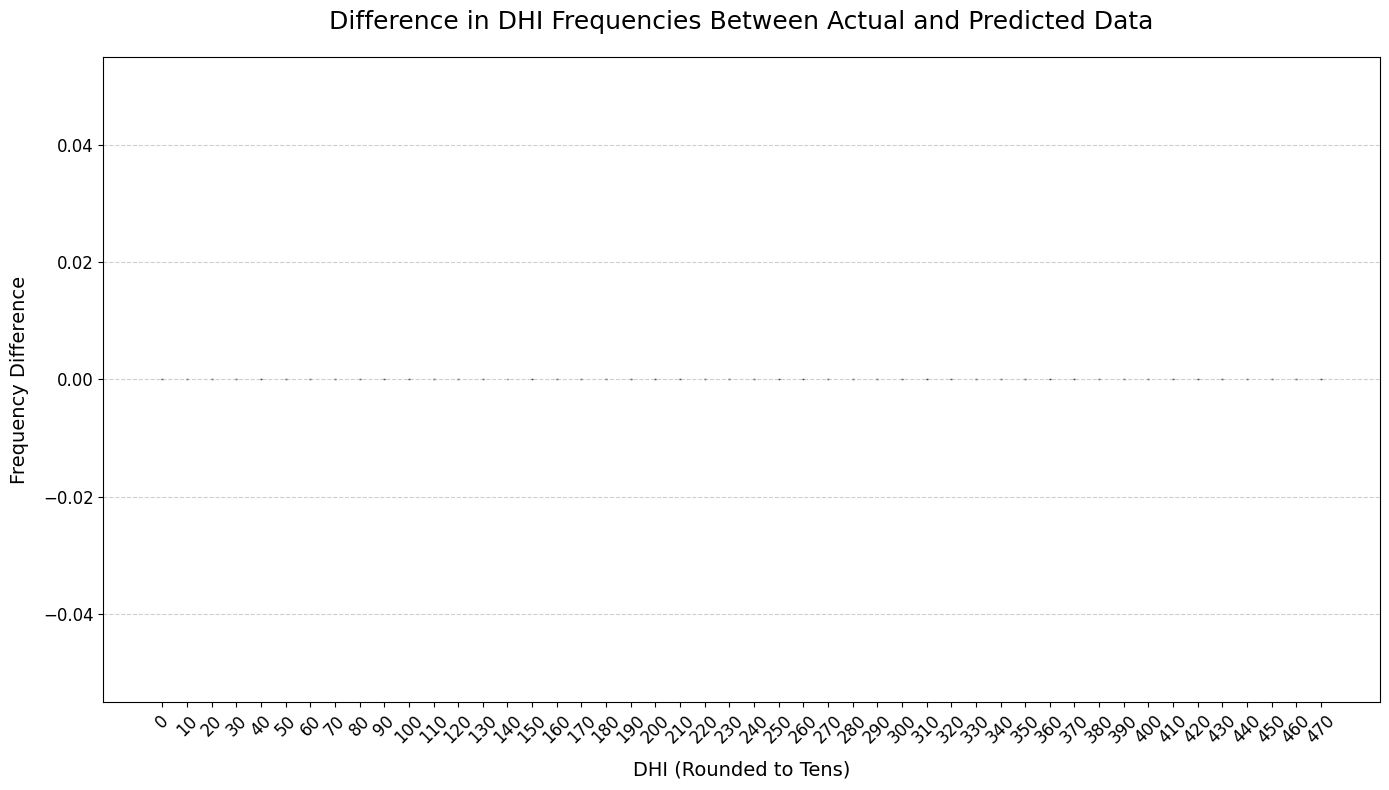

In [49]:
difference_bar(historical_data_filtered['DHI'], prediction_data_filtered['DHI'], "Difference in DHI Frequencies Between Actual and Predicted Data with 0",flag=True)

Chart saved to /data/processed_data/smpc_histogram_processed/smpc_2017/


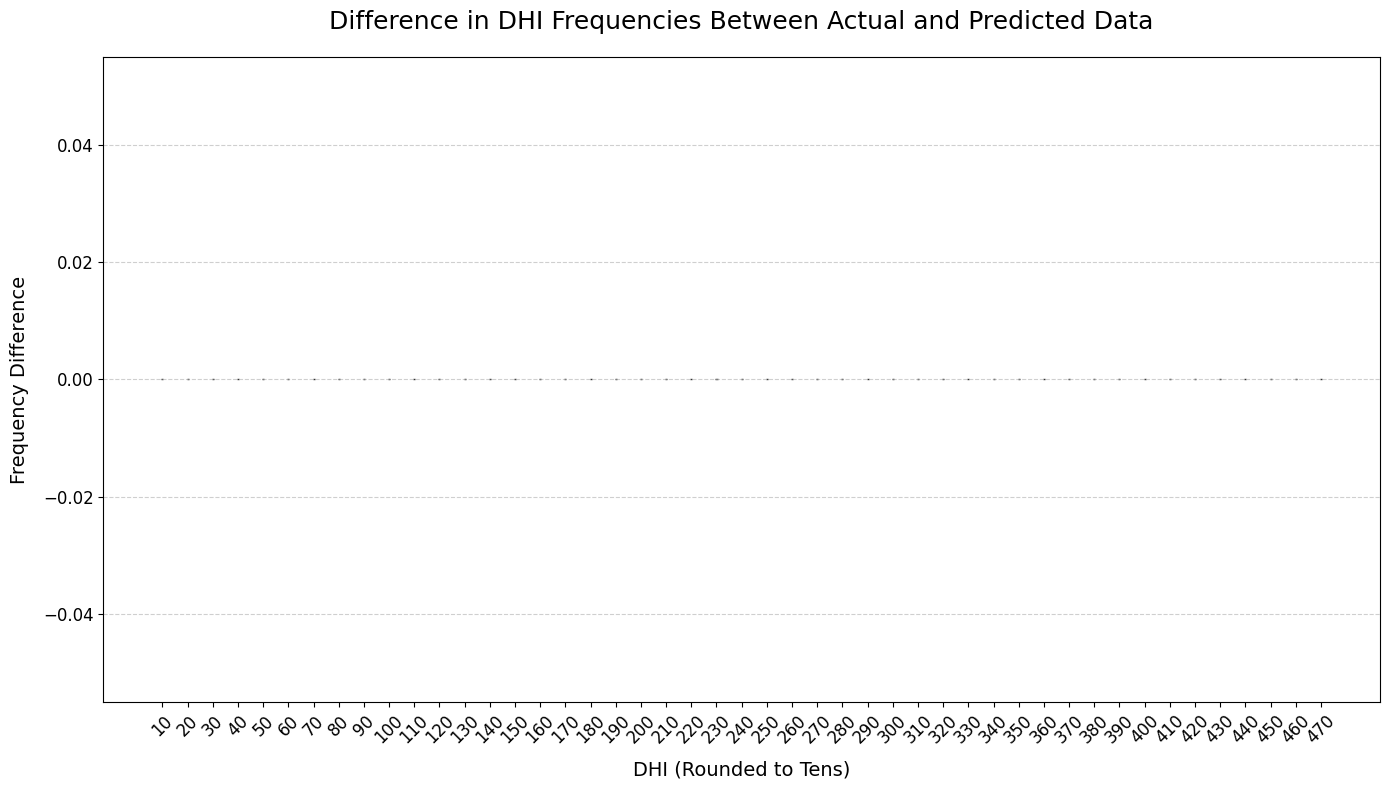

In [50]:
difference_bar(historical_data_filtered['DHI'], prediction_data_filtered['DHI'], "Difference in DHI Frequencies Between Actual and Predicted Data",flag=False)